<a href="https://colab.research.google.com/github/ViniciusTavaresSousa/Deteccao-de-Soja-com-U-Net-e-MapBiomas/blob/main/U_NET_MapBiomas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

#**Google Drive**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

#**Modelo**

##**Configurações**

In [2]:
input_shape = (5, 128, 128, 6)
latent_size = 64
batch_size = 64
buffer_size = 5000
epochs = 500

In [3]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

##**Base de Dados**

In [4]:
dataset = np.load("/content/drive/MyDrive/U-Net_MapBiomas/dataset.npy")

x = dataset[:, :, :, :6, :]
y = dataset[:, :, :, 6:, :]

x = np.transpose(x, (0, 4, 1, 2, 3))
y = np.transpose(y, (0, 4, 1, 2, 3))

x.shape, np.max(x), np.min(x)
y.shape, np.max(y), np.min(y)

((13970, 5, 128, 128, 1), np.float32(1.0), np.float32(0.0))

In [5]:
media_percentual = np.mean(y, axis=(1, 2, 3, 4)) * 100

bins = np.arange(0, 85.5, 0.5)
histograma, limites = np.histogram(media_percentual, bins=bins)

max_por_faixa = 30
indices_balanceados = []

mascara_zero = media_percentual == 0
indices_zero = np.where(mascara_zero)[0]

if len(indices_zero) > max_por_faixa:
    selecionados_zero = np.random.choice(indices_zero, max_por_faixa, replace=False)
else:
    selecionados_zero = indices_zero

indices_balanceados.extend(selecionados_zero)

for i in range(1, len(histograma)):
    mascara_faixa = (media_percentual >= limites[i]) & (media_percentual < limites[i+1])
    indices_faixa = np.where(mascara_faixa)[0]

    if len(indices_faixa) == 0:
        continue

    if len(indices_faixa) > max_por_faixa:
        selecionados = np.random.choice(indices_faixa, max_por_faixa, replace=False)
    else:
        selecionados = indices_faixa

    indices_balanceados.extend(selecionados)

x = x[indices_balanceados]
y = y[indices_balanceados]

media_percentual_balanceada = np.mean(y, axis=(1, 2, 3, 4)) * 100
hist_final, limites_finais = np.histogram(media_percentual_balanceada, bins=bins)

print("\nBalanceamento:")
for i in range(len(hist_final)):
    print(f"{limites_finais[i]:.1f}–{limites_finais[i+1]:.1f}%: {hist_final[i]} amostras")

print(f"\nTotal de amostras: {np.sum(hist_final)}")


Balanceamento:
0.0–0.5%: 30 amostras
0.5–1.0%: 30 amostras
1.0–1.5%: 30 amostras
1.5–2.0%: 30 amostras
2.0–2.5%: 30 amostras
2.5–3.0%: 30 amostras
3.0–3.5%: 30 amostras
3.5–4.0%: 30 amostras
4.0–4.5%: 30 amostras
4.5–5.0%: 30 amostras
5.0–5.5%: 30 amostras
5.5–6.0%: 30 amostras
6.0–6.5%: 30 amostras
6.5–7.0%: 30 amostras
7.0–7.5%: 30 amostras
7.5–8.0%: 30 amostras
8.0–8.5%: 30 amostras
8.5–9.0%: 30 amostras
9.0–9.5%: 30 amostras
9.5–10.0%: 30 amostras
10.0–10.5%: 30 amostras
10.5–11.0%: 30 amostras
11.0–11.5%: 30 amostras
11.5–12.0%: 30 amostras
12.0–12.5%: 30 amostras
12.5–13.0%: 30 amostras
13.0–13.5%: 30 amostras
13.5–14.0%: 30 amostras
14.0–14.5%: 30 amostras
14.5–15.0%: 30 amostras
15.0–15.5%: 30 amostras
15.5–16.0%: 30 amostras
16.0–16.5%: 30 amostras
16.5–17.0%: 30 amostras
17.0–17.5%: 30 amostras
17.5–18.0%: 30 amostras
18.0–18.5%: 30 amostras
18.5–19.0%: 30 amostras
19.0–19.5%: 30 amostras
19.5–20.0%: 30 amostras
20.0–20.5%: 30 amostras
20.5–21.0%: 30 amostras
21.0–21.5%: 30 

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=SEED)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

##**Encoder**

In [7]:
def criaEncoder():
    entrada = tf.keras.Input(shape=input_shape)

    x = layers.Conv3D(32, (8,8,8), strides=(1,2,2), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(entrada)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    skip1 = x

    x = layers.Conv3D(64, (4,4,4), strides=(1,2,2), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    skip2 = x

    x = layers.Conv3D(128, (2,2,2), strides=(1,2,2), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    skip3 = x

    x = layers.Flatten()(x)
    saida = layers.Dense(latent_size)(x)

    modelo = tf.keras.Model(entrada, [saida, skip1, skip2, skip3], name="Encoder")
    modelo.summary()

    return modelo

In [8]:
encoder = criaEncoder()

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5, 128, 128, 6) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 5, 64, 64, 32)  │        98,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 5, 64, 64, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 5, 64, 64, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 64, 64, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 5, 32, 32, 64)  │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 5, 32, 32, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 5, 32, 32, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 32, 32, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 5, 16, 16, 128) │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 5, 16, 16, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 16, 16, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 16, 16, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 163840)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    10,485,824 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,781,856 (41.13 MB)

 Trainable params: 10,781,408 (41.13 MB)

 Non-trainable params: 448 (1.75 KB)

##**Decoder**

In [9]:
def criaDecoder():
    entrada = tf.keras.Input(shape=(latent_size,))

    skip1 = tf.keras.Input(shape=(5,64,64,32))
    skip2 = tf.keras.Input(shape=(5,32,32,64))
    skip3 = tf.keras.Input(shape=(5,16,16,128))

    x = layers.Dense(5*16*16*128)(entrada)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((5,16,16,128))(x)

    x = layers.Concatenate()([x, skip3])
    x = layers.Conv3DTranspose(128, (2,2,2), strides=(1,2,2), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Concatenate()([x, skip2])
    x = layers.Conv3DTranspose(64, (4,4,4), strides=(1,2,2), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Concatenate()([x, skip1])
    x = layers.Conv3DTranspose(32, (8,8,8), strides=(1,2,2), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    saida = layers.Conv3DTranspose(1, (3,3,3), activation='sigmoid', padding='same')(x)

    modelo = tf.keras.Model([entrada, skip1, skip2, skip3], saida, name="Decoder")
    modelo.summary()

    return modelo

In [10]:
decoder = criaDecoder()

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 163840)    │ 10,649,600 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 163840)    │          0 │ dense_1[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 5, 16, 16, │          0 │ leaky_re_lu_3[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 5, 16, 16, │          0 │ -                 │
│ (InputLayer)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 5, 16, 16, │          0 │ reshape[0][0],    │
│ (Concatenate)       │ 256)              │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_transpose    │ (None, 5, 32, 32, │    262,272 │ concatenate[0][0] │
│ (Conv3DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 5, 32, 32, │          0 │ conv3d_transpose… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 32, 32, │        512 │ leaky_re_lu_4[0]… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 5, 32, 32, │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 5, 32, 32, │          0 │ -                 │
│ (InputLayer)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 5, 32, 32, │          0 │ dropout_3[0][0],  │
│ (Concatenate)       │ 192)              │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_transpose_1  │ (None, 5, 64, 64, │    786,496 │ concatenate_1[0]… │
│ (Conv3DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 5, 64, 64, │          0 │ conv3d_transpose… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 64, 64, │        256 │ leaky_re_lu_5[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 5, 64, 64, │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 5, 64, 64, │          0 │ -                 │
│ (InputLayer)        │ 32)               │            │                 

 Total params: 13,273,025 (50.63 MB)

 Trainable params: 13,272,577 (50.63 MB)

 Non-trainable params: 448 (1.75 KB)

##**U-NET**

In [11]:
unet = tf.keras.Model(encoder.input, decoder(encoder.output), name="unet")
unet.summary()

Model: "unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5, 128,    │          0 │ -                 │
│ (InputLayer)        │ 128, 6)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 5, 64, 64, │     98,336 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 5, 64, 64, │          0 │ conv3d[0][0]      │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 5, 64, 64, │        128 │ leaky_re_lu[0][0] │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 5, 64, 64, │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 5, 32, 32, │    131,136 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 5, 32, 32, │          0 │ conv3d_1[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 32, 32, │        256 │ leaky_re_lu_1[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 5, 32, 32, │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 5, 16, 16, │     65,664 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 5, 16, 16, │          0 │ conv3d_2[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 16, 16, │        512 │ leaky_re_lu_2[0]… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 5, 16, 16, │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 163840)    │          0 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │ 10,485,824 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder             │ (None, 5, 128,    │ 13,273,025 │ dense[0][0],      │
│ (Functional)        │ 128, 1)           │            │ dropout[0][0],    │
│                     │                   │            │ dropout_1[0][0],  │
│                     │                   │            │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,054,881 (91.76 MB)

 Trainable params: 24,053,985 (91.76 MB)

 Non-trainable params: 896 (3.50 KB)

##**Perda**

In [12]:
def perda(y_true, y_pred, smooth=1e-6):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])

    proporcao_pos = tf.reduce_mean(y_true_flat)
    proporcao_neg = 1.0 - proporcao_pos

    proporcao_pos = tf.maximum(proporcao_pos, smooth)
    proporcao_neg = tf.maximum(proporcao_neg, smooth)

    peso_pos = 1.0 / (2.0 * proporcao_pos)
    peso_neg = 1.0 / (2.0 * proporcao_neg)

    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    bce = tf.reshape(bce, [-1])

    pesos = y_true_flat * peso_pos + (1.0 - y_true_flat) * peso_neg
    bce_balanceado = tf.reduce_mean(pesos * bce)

    intersecao = tf.reduce_sum(y_true_flat * y_pred_flat)
    dice = 1 - (2. * intersecao + smooth) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + smooth)

    return bce_balanceado + dice

##**Treinamento**

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=perda)

unet.fit(train_dataset, validation_data=val_dataset, epochs=epochs, callbacks=[early_stopping])

Epoch 1/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 51s 505ms/step - loss: 0.9702 - val_loss: 8.4698
Epoch 2/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 489ms/step - loss: 0.6177 - val_loss: 0.6584
Epoch 3/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 489ms/step - loss: 0.5602 - val_loss: 0.6378
Epoch 4/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 489ms/step - loss: 0.5138 - val_loss: 0.5923
Epoch 5/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 489ms/step - loss: 0.4971 - val_loss: 0.5901
Epoch 6/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 488ms/step - loss: 0.5645 - val_loss: 0.7603
Epoch 7/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 488ms/step - loss: 0.4785 - val_loss: 0.7797
Epoch 8/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 488ms/step - loss: 0.4574 - val_loss: 0.6800
Epoch 9/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 488ms/step - loss: 0.4329 - val_loss: 1.1620
Epoch 10/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 488ms/step - loss: 0.4316 - val_loss: 0.9603
Epoch 11/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 488ms/step - loss: 0.4127 - val_loss: 0.6170
Epoch 12/500
72/72 ━━━━━━━━━━━

In [14]:
unet.save("/content/drive/MyDrive/U-Net_MapBiomas/unet.keras")

##**Resultados**

In [27]:
unet = keras.models.load_model("/content/drive/MyDrive/U-Net_MapBiomas/unet.keras", custom_objects={"perda": perda})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


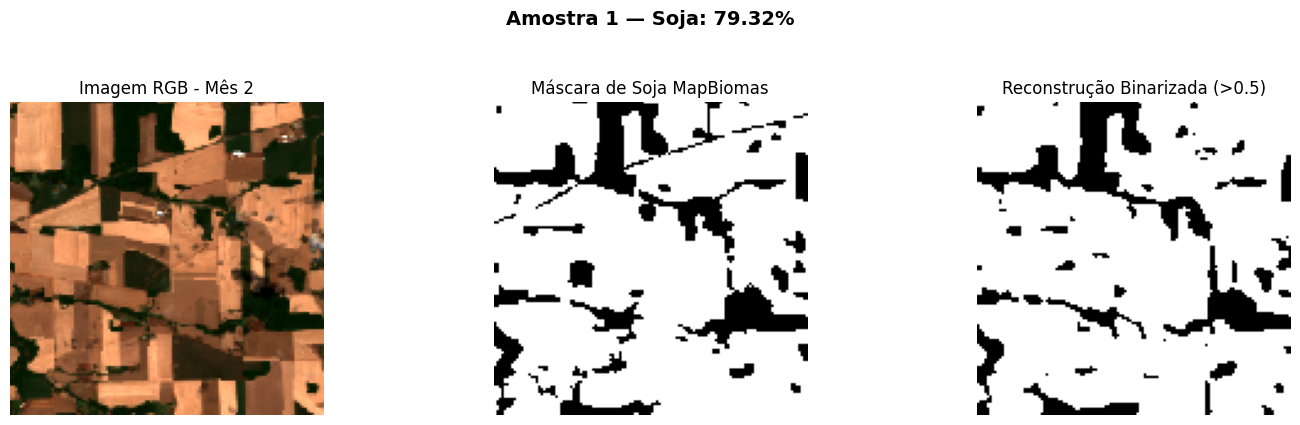

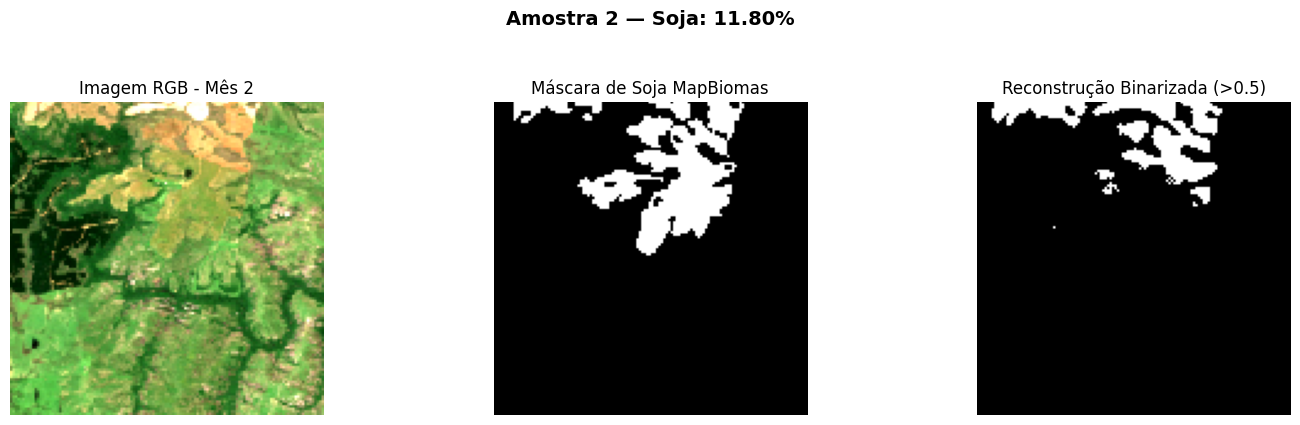

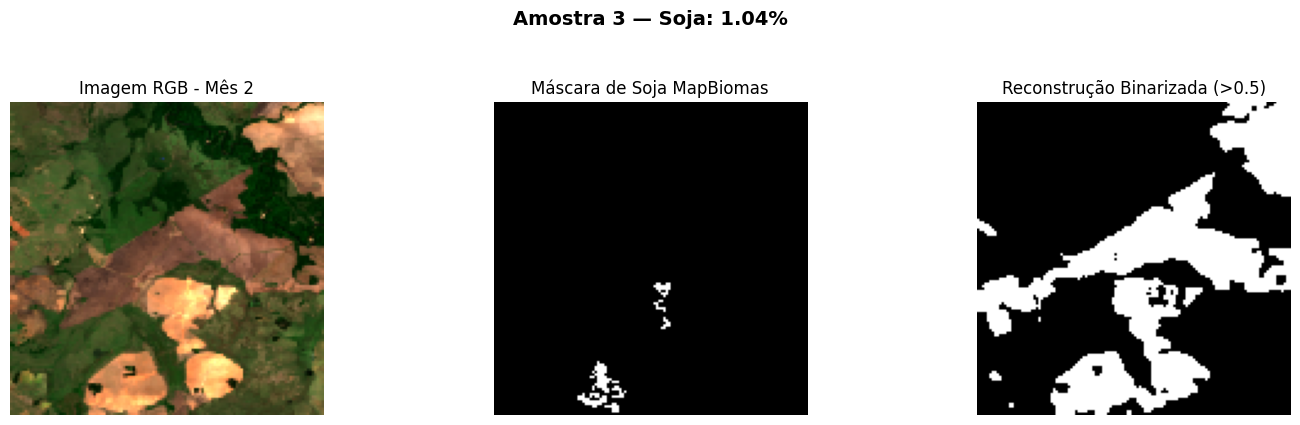

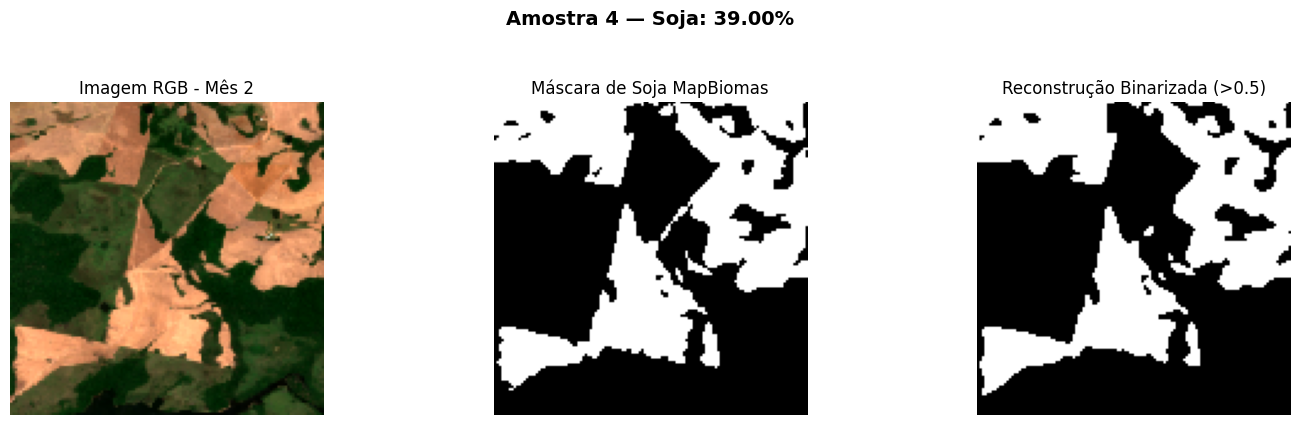

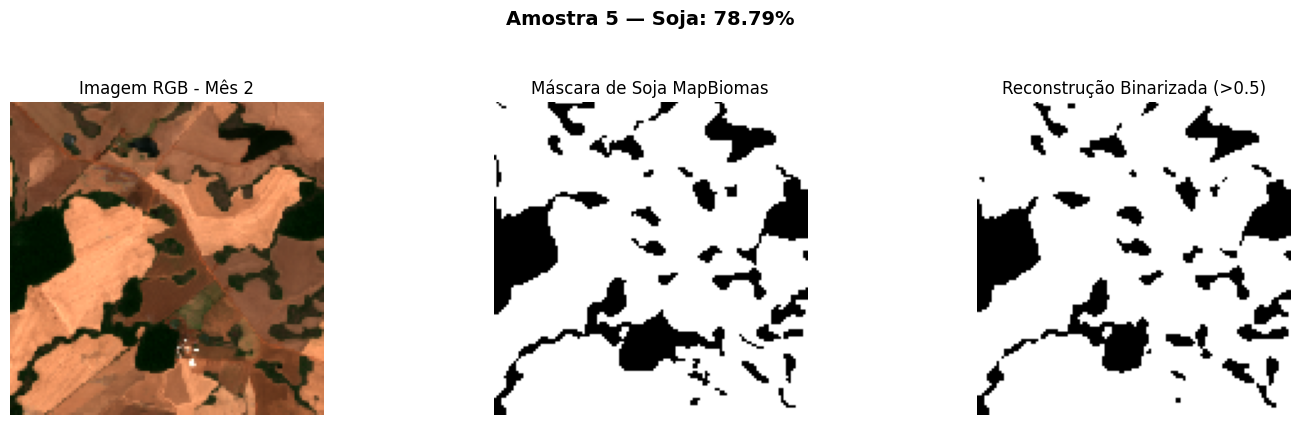

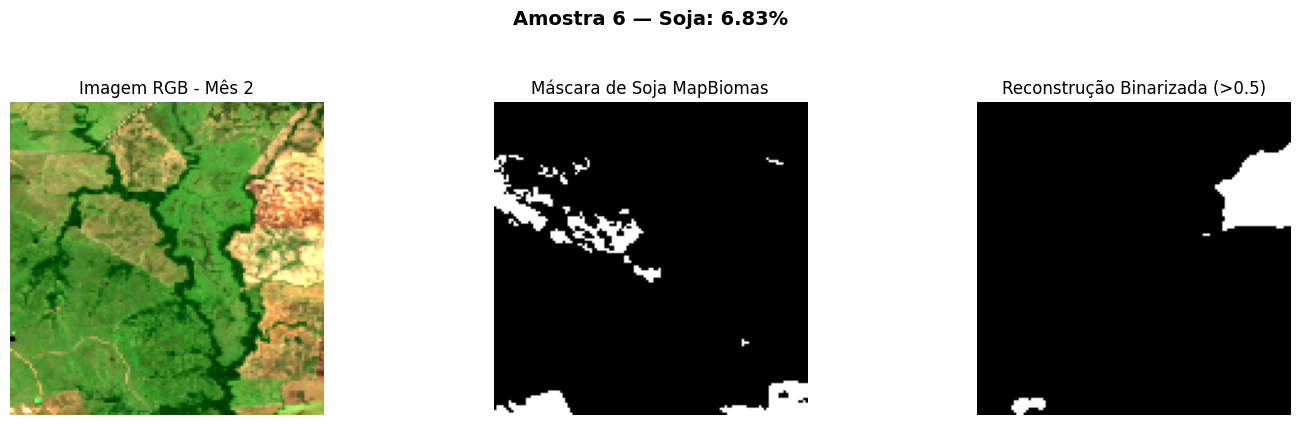

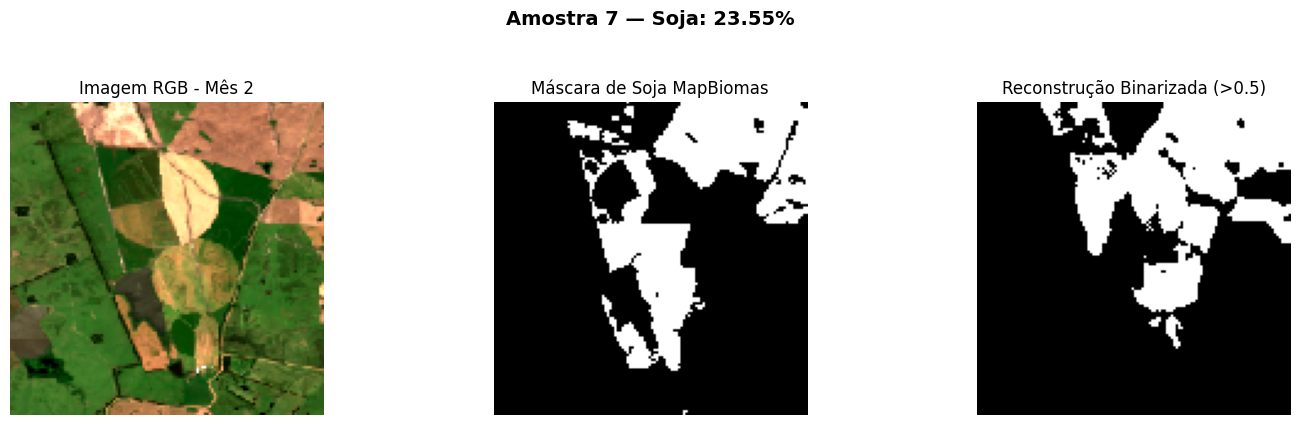

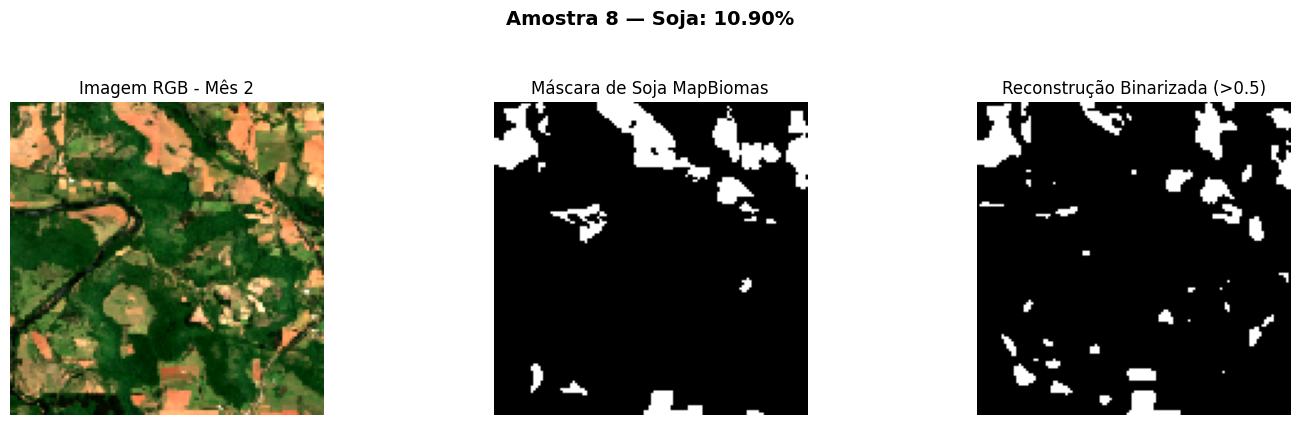

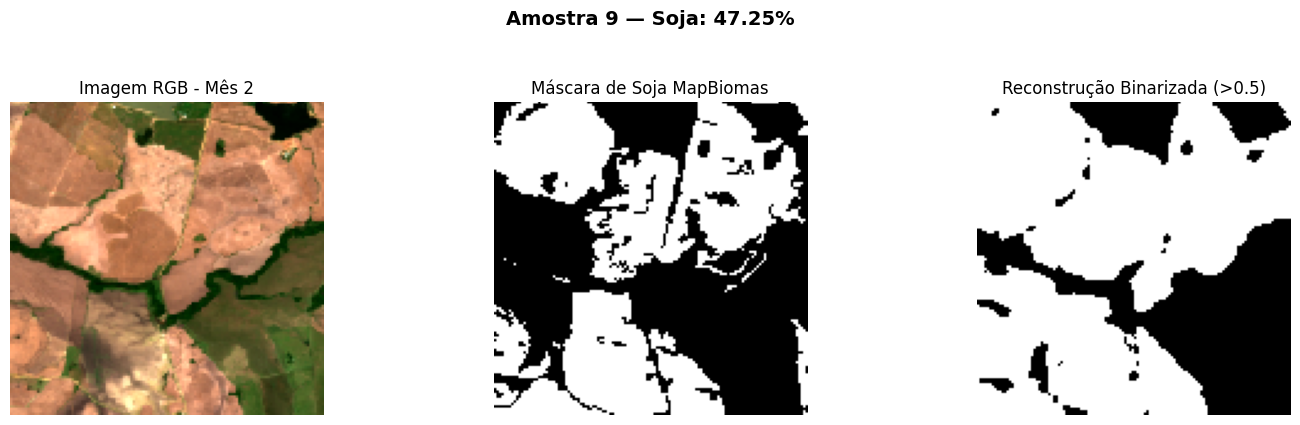

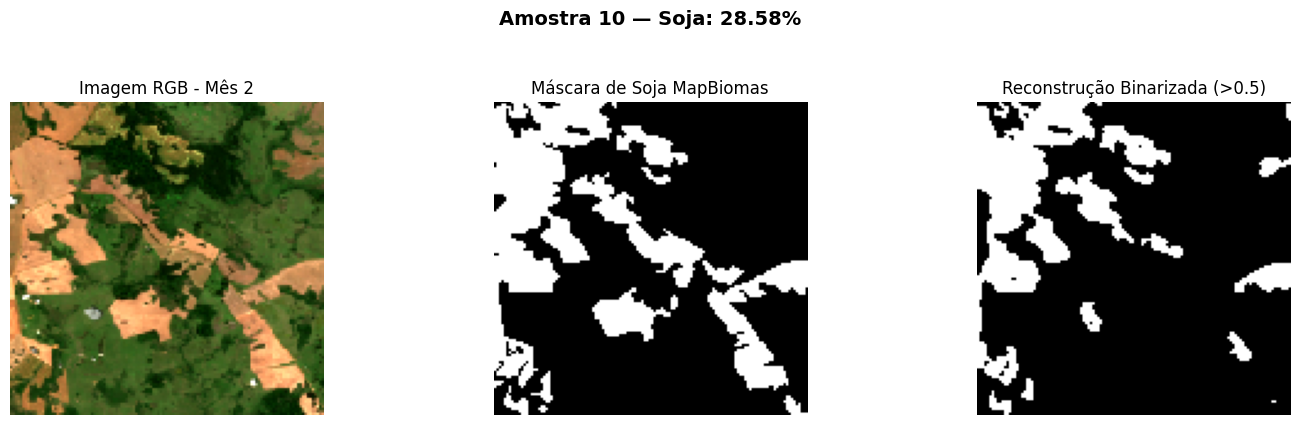

In [28]:
def melhorar_imagem(img, pmin=2, pmax=98):
    vmin, vmax = np.percentile(img, (pmin, pmax))
    return np.clip((img - vmin) / (vmax - vmin), 0, 1)

amostras_x = x_val[:10]
amostras_y = y_val[:10]
predicoes = unet.predict(amostras_x)

limiar = 0.5
predicoes_bin = (predicoes > limiar).astype(np.float32)

indice_frame = 1

for i in range(len(amostras_x)):
    plt.figure(figsize=(15, 4))

    perc_soja = np.mean(amostras_y[i][indice_frame, :, :, 0]) * 100

    plt.subplot(1, 3, 1)
    rgb = amostras_x[i][indice_frame, :, :, [2, 1, 0]]
    rgb = melhorar_imagem(rgb)
    if rgb.shape[0] == 3 and rgb.shape[-1] != 3:
        rgb = np.transpose(rgb, (1, 2, 0))
    plt.imshow(rgb)
    plt.title(f'Imagem RGB - Mês {indice_frame+1}', fontsize=12)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(amostras_y[i][indice_frame, :, :, 0], cmap='gray')
    plt.title('Máscara de Soja MapBiomas', fontsize=12)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicoes_bin[i][indice_frame, :, :, 0], cmap='gray')
    plt.title(f'Reconstrução Binarizada (>{limiar})', fontsize=12)
    plt.axis('off')

    plt.suptitle(f"Amostra {i+1} — Soja: {perc_soja:.2f}%",
                 fontsize=14, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()
